# ML-IMC

In [274]:
using Dates
using Plots
using Statistics
using LinearAlgebra
using Distributed

if nworkers() == 1
    BLAS.set_num_threads(1)
    addprocs(4)
end

@everywhere begin
    include("src/distances.jl")
    include("src/readLJ.jl")
    include("src/ML-IMC.jl");
end

## 1. The first simulation

## 1.1. Input data 

In [3]:
xyz = readXYZ("mctraj-p001.xyz")
conf = xyz[end]

bins, rdfref, histref = readRDF("rdf-mean-p40.dat")

parameters = readinput("LJML-init.in")

model = Dense(length(histref), 1, tanh, bias=true);

Reading mctraj-p001.xyz with 6012 lines...
Found 6 frames with 1000 atoms each...
Success! Closing the file...


## 1.2. Running the simulation

In [4]:
function main(conf, parameters, model)    
    # Start the timer
    startTime = Dates.now()
    println("Running MC simulation on $(nworkers()) rank(s)...\n")
    println("Starting at: ", startTime)
    
    # Prepare inputs
    input = conf, parameters, model
    inputs = [input for worker in workers()]
    
    # Run the simulation in parallel
    outputs = pmap(mcrun!, inputs)
    
    # Stop the timer
    stopTime = Dates.now()
    wallTime = Dates.canonicalize(stopTime - startTime)
    println("Stopping at: ", stopTime, "\n")
    println("Walltime: ", wallTime)
    
    return(outputs)
end;

In [31]:
println("Running simulation for $(parameters.steps * nworkers() / 1E6)M total MC steps...")

Running simulation for 40.0M total MC steps...


In [5]:
outputs = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Starting at: 2022-03-24T17:47:21.271
      From worker 5:	Acceptance ratio = 0.7713024
      From worker 3:	Acceptance ratio = 0.7714867
      From worker 4:	Acceptance ratio = 0.7710791
      From worker 2:	Acceptance ratio = 0.7708904
Stopping at: 2022-03-24T17:54:39.150

Walltime: 7 minutes, 17 seconds, 879 milliseconds


Mean histogram:

In [46]:
histNN = mean([output[1] for output in outputs]);

Averaging energies from each worker:

In [47]:
energies = mean([output[2] for output in outputs]);

## 1.3. Analysis

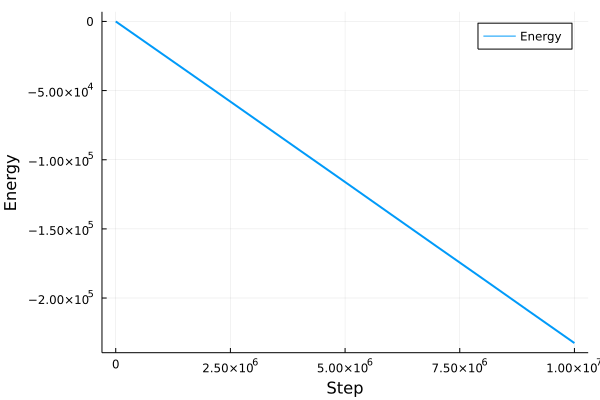

In [48]:
slicing = Int(1E4)
steps = 0:parameters.outfreq:parameters.steps
plot(steps[1:slicing:end], energies[1:slicing:end], lw=2, labels="Energy")
xlabel!("Step")
ylabel!("Energy")

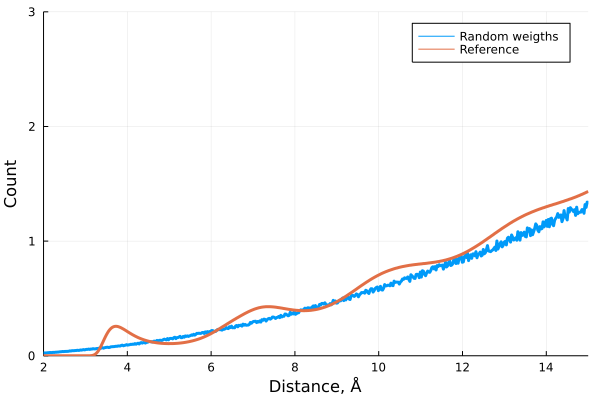

In [51]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Random weigths")
plot!(bins, histref./500, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")

The first iteration is done. Now it is time for training!

## 1.4. Setting up the training

Normalize the reference histogram (so we get per particle histogram):

In [74]:
histref = histref./500

600-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.388374
 1.392604
 1.39594
 1.399926
 1.404266
 1.407718
 1.411834
 1.416304
 1.42021
 1.424844
 1.4290440000000002
 1.4332

In [75]:
function loss(histNN, histref)
    loss = 0.
    for i in 1:length(histref)
        loss += (histNN[i] - histref[i])^2
    end
    return(loss)
end;

In [226]:
loss(histNN, histref)

4.289440374549

Now I will try to compute $ \langle \frac{\partial H}{\partial \lambda_i} \rangle $.

In [227]:
dHdw, dHdb = gradient(neuralenergy, histNN, model)[2];

It seems to be working! In my case, the first argument of the gradient function is the gradient of neuralenergy function output (hamiltonian) with respect to the first agrument, `histNN`. The second argument is the argument that I need - the gradient of the neuralenergy with respect to the model parameters!

In [230]:
dHdw

1×600 Matrix{Float64}:
 0.0  4.74729e-6  1.01728e-5  1.8311e-5  …  0.351162  0.363543  0.362935

In [231]:
dHdb

1-element Vector{Float32}:
 0.27127367

I will build the $ \langle \frac{\partial H}{\partial \lambda_j} \rangle  \langle S_i \rangle$ terms separately for weights and biases:

In [232]:
histNN * dHdw

600×600 Matrix{Float64}:
 0.0  0.0          0.0          0.0          …  0.0          0.0
 0.0  8.30776e-11  1.78023e-10  3.20442e-10     6.362e-6     6.35136e-6
 0.0  1.78023e-10  3.81479e-10  6.86661e-10     1.36328e-5   1.36101e-5
 0.0  3.20442e-10  6.86661e-10  1.23599e-9      2.45391e-5   2.44981e-5
 0.0  4.62861e-10  9.91844e-10  1.78532e-9      3.54454e-5   3.53862e-5
 0.0  6.17148e-10  1.32246e-9   2.38043e-9   …  4.72605e-5   4.71816e-5
 0.0  7.47698e-10  1.60221e-9   2.88398e-9      5.7258e-5    5.71623e-5
 0.0  1.15122e-9   2.46689e-9   4.44041e-9      8.81591e-5   8.80117e-5
 0.0  1.45979e-9   3.12812e-9   5.63062e-9      0.000111789  0.000111603
 0.0  1.86331e-9   3.99281e-9   7.18706e-9      0.00014269   0.000142452
 0.0  2.23123e-9   4.7812e-9    8.60616e-9   …  0.000170865  0.000170579
 0.0  2.49233e-9   5.3407e-9    9.61326e-9      0.00019086   0.000190541
 0.0  3.24002e-9   6.94291e-9   1.24972e-8      0.000248118  0.000247703
 ⋮                                       

In [234]:
histNN .* dHdb

600-element Vector{Float64}:
 0.0
 4.7472892701625826e-6
 1.0172762721776964e-5
 1.8310972899198533e-5
 2.64491830766201e-5
 3.5265577435493466e-5
 4.2725603431463246e-5
 6.578386560082435e-5
 8.341665431857109e-5
 0.0001064749164879322
 0.00012749862611293792
 0.00014241867810487746
 0.0001851442815363407
 ⋮
 0.3516018761369586
 0.33607010201334947
 0.338736722214818
 0.3398035059322417
 0.33982724237859246
 0.3458780016455054
 0.3457220192837715
 0.3371436675725878
 0.35779030679270624
 0.3511617346031964
 0.3635426650197804
 0.3629350119931996

I need to collect the cross-product term $ \langle \frac{\partial H}{\partial \lambda_j} S_i \rangle$ during the simulation.

I will prototype the calculation here:

In [224]:
N = length(conf)
pointIndex = 1
distanceVector = zeros(N)
updatedistance!(conf, parameters.box, distanceVector, pointIndex);

hist = zeros(parameters.Nbins);
histpart!(distanceVector, hist, parameters.binWidth);

In [235]:
dHdw, dHdb = gradient(neuralenergy, hist, model)[2];

In [237]:
hist * dHdw

600×600 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0      0.0       0.0
 ⋮                        ⋮            

In [250]:
hist .* dHdb

600-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.3805176913738251
 1.5220707654953003
 0.3805176913738251
 0.7610353827476501
 0.3805176913738251
 1.1415530741214752
 0.7610353827476501
 1.1415530741214752
 1.1415530741214752
 0.3805176913738251
 0.3805176913738251

I need to accumulate those arrays during the simulation.